In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.5 MB/s eta 0:00:00
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

## The Practice of Deep Learning

### Starting Your Project

### The State of Deep Learning

#### Computer vision

#### Text (natural language processing)

#### Combining text and images

#### Tabular data

#### Recommendation systems

#### Other data types

### The Drivetrain Approach

## Gathering Data

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [ ]:
# Skipping this line of code due to I'll be using DuckDuckGo instead of Bing Image Search
# key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [8]:
#search_images_bing
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [9]:
# results = search_images_bing(key, 'grizzly bear')
# ims = results.attrgot('contentUrl')
ims = search_images_ddg('grizzly bear')
len(ims)

200

In [10]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

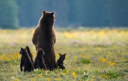

In [11]:
im = Image.open(dest)
im.to_thumb(128,128)

In [12]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [13]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
#       results = search_images_bing(key, f'{o} bear')
        results = search_images_ddg(f'{o} bear')
#       download_images(dest, urls=results.attrgot('contentUrl'))
        download_images(dest, urls=results)

In [14]:
fns = get_image_files(path)
fns

(#563) [Path('bears/grizzly/beca3893-2ff0-4005-b9dd-8cf8d499b093.jpg'),Path('bears/grizzly/525e42a4-66e5-4cbc-bcd6-280e9b92523e.jpg'),Path('bears/grizzly/1c9d11bb-04c6-4bbd-a197-1c13ecb563b9.jpg'),Path('bears/grizzly/29d70336-edd7-410e-8c90-5fdf854b6802.jpg'),Path('bears/grizzly/55eb4cf5-82f3-4345-a0a5-bd7bd98d18d9.jpg'),Path('bears/grizzly/6dc88560-ed74-4d7a-b38a-53594fd28da0.jpg'),Path('bears/grizzly/d20ba223-4678-4c2f-8059-f7425803b208.jpg'),Path('bears/grizzly/60cc3150-bdfa-4453-9fda-da2ac0d559bc.jpg'),Path('bears/grizzly/3a3b5808-3abc-4eaf-aef6-c46fe063c5a7.jpg'),Path('bears/grizzly/9e76e16c-fff7-4b5e-b1b3-405ee2f046f7.jpg')...]

In [15]:
failed = verify_images(fns)
failed

(#26) [Path('bears/grizzly/3d86329d-c6e2-4689-adeb-61d2a09c76bf.jpg'),Path('bears/grizzly/603c071a-dd90-4a8d-bae3-b7b9e023143a.jpg'),Path('bears/grizzly/8c603436-72e9-4fb5-a288-f546b5761879.jpg'),Path('bears/black/3eaf34d5-78f3-482b-8bed-28839e44a867.jpg'),Path('bears/black/a526316c-87df-426a-b479-028b6fc785ce.jpg'),Path('bears/black/e21adbbf-1db1-49a4-8b6f-b3f3b74ba33e.png'),Path('bears/black/bf2608ab-d464-4621-9924-9bc9d4a66cce.jpg'),Path('bears/black/deab5327-c6cc-40ae-b681-935424ba78ec.jpg'),Path('bears/teddy/edfafbc3-680e-4e22-85b6-1028aff92588.JPG'),Path('bears/teddy/0382526d-6215-4162-ac25-22ce3fedf1ee.JPG')...]

In [16]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

In [14]:
??verify_images

### End sidebar

## From Data to DataLoaders

In [17]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [18]:
dls = bears.dataloaders(path)

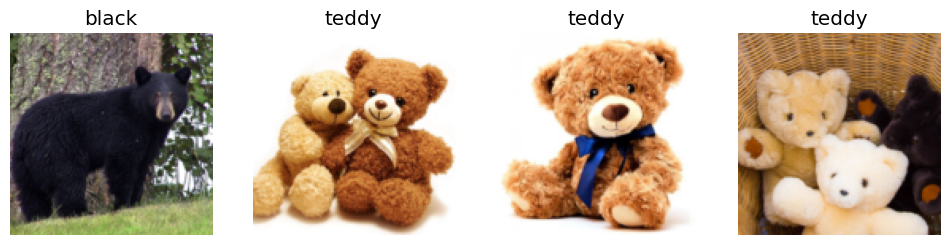

In [19]:
dls.valid.show_batch(max_n=4, nrows=1)

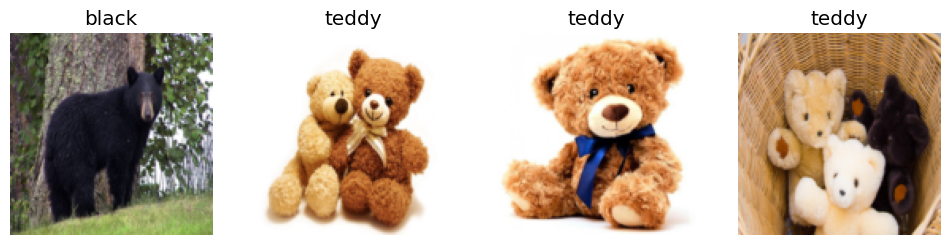

In [20]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

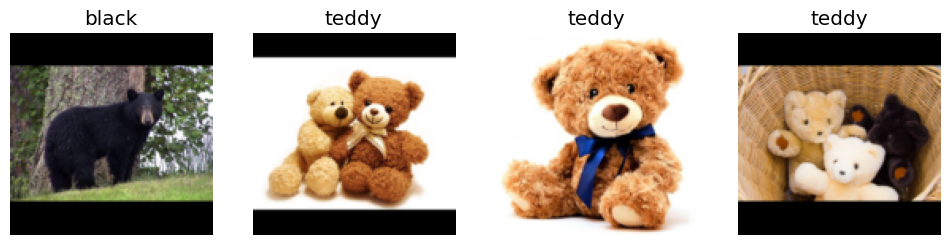

In [21]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

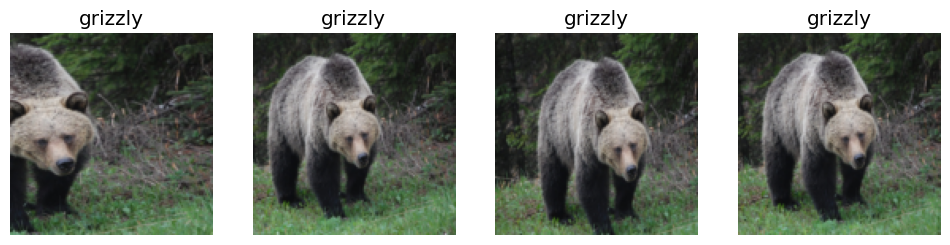

In [22]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

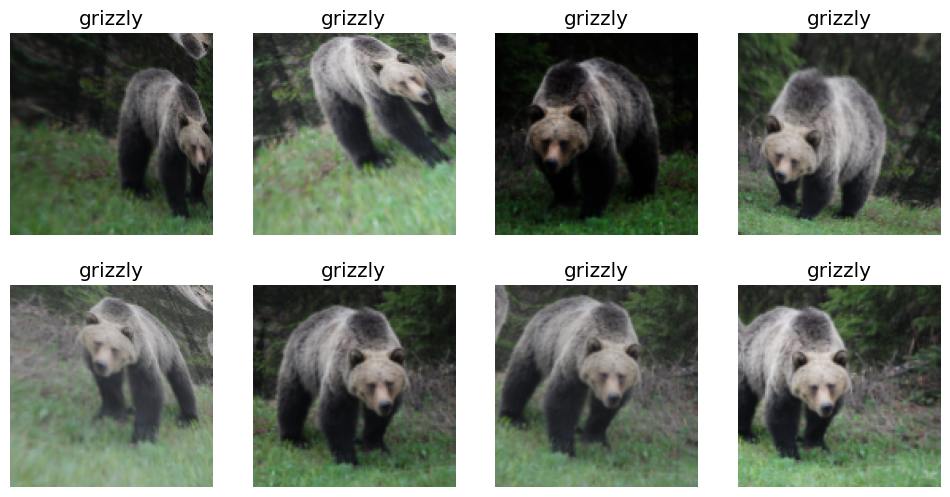

In [23]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/grizzly.jpg')

In [ ]:
learn_inf.dls.vocab

### Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila

### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.

  A:For instance, if there were no black-and-white images in the training data, the model may do poorly on black-and-white images. Similarly, if the training data did not contain hand-drawn images, then the model will probably do poorly on hand-drawn images.
1. Where do text models currently have a major deficiency?

  A: Deep learning is currently not good at generating *correct* responses! We don't currently have a reliable way to, for instance, combine a knowledge base of medical information with a deep learning model for generating medically correct natural language responses. This is very dangerous, because it is so easy to create content that appears to a layman to be compelling, but actually is entirely incorrect.
1. What are possible negative societal implications of text generation models?

  A: Another concern is that context-appropriate, highly compelling responses on social media could be used at massive scale—thousands of times greater than any troll farm previously seen—to spread disinformation, create unrest, and encourage conflict.
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?

  A: As a rule of thumb, text generation models will always be technologically a bit ahead of models recognizing automatically generated text. For instance, it is possible to use a model that can recognize artificially generated content to actually improve the generator that creates that content, until the classification model is no longer able to complete its task.
1. What kind of tabular data is deep learning particularly good at?

  A: Deep learning does greatly increase the variety of columns that you can include—for example, columns containing natural language (book titles, reviews, etc.), and high-cardinality categorical columns (i.e., something that contains a large number of discrete choices, such as zip code or product ID).
1. What's a key downside of directly using a deep learning model for recommendation systems?

  A: Deep learning models generally take longer to train than random forests or gradient boosting machines
1. What are the steps of the Drivetrain Approach?

  A: The basic idea is to start with considering your objective, then think about what actions you can take to meet that objective and what data you have (or can acquire) that can help, and then build a model that you can use to determine the best actions to take to get the best results in terms of your objective.
1. How do the steps of the Drivetrain Approach map to a recommendation system?

  A: Let's consider another example: recommendation systems. The *objective* of a recommendation engine is to drive additional sales by surprising and delighting the customer with recommendations of items they would not have purchased without the recommendation. The *lever* is the ranking of the recommendations. New *data* must be collected to generate recommendations that will *cause new sales*. This will require conducting many randomized experiments in order to collect data about a wide range of recommendations for a wide range of customers.
1. Create an image recognition model using data you curate, and deploy it on the web.

  A: Done
1. What is `DataLoaders`?

  A: `DataLoaders` is a thin class that just stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid`. Although it's a very simple class, it's very important in fastai: it provides the data for your model.
1. What four things do we need to tell fastai to create `DataLoaders`?

  A:  To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

  - What kinds of data we are working with
  - How to get the list of items
  - How to label these items
  - How to create the validation set
1. What does the `splitter` parameter to `DataBlock` do?

  A: It splits our training and validation sets randomly
1. How do we ensure a random split always gives the same validation set?

  A: We fix the random seed parameter (computers don't really know how to create random numbers at all, but simply create lists of numbers that look random; if you provide the same starting point for that list each time—called the *seed*—then you will get the exact same list each time)
1. What letters are often used to signify the independent and dependent variables?

  A: The independent variable is often referred to as `x` and the dependent variable is often referred to as `y`
1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?

  A: Crop, *crops* the images to fit a square shape of the size requested, using the full width or height. Squish, stretches the images to fit a square shape and Pad, pads the image with zeros (black);
  
  All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to perform recognition. For instance, if we were trying to recognize breeds of dog or cat, we might end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.

  Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

1. What is data augmentation? Why is it needed?

  A: *Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes.
1. What is the difference between `item_tfms` and `batch_tfms`?

  A: item_tfms stands for *Item transforms* which are pieces of code that run on each individual item, whether it be an image, category, or so forth. It used to resize the images.

  bactch_tfms stands for *Batch transforms* and it used to tell fastai we want to apply data augmentation transforms on a batch of data
1. What is a confusion matrix?

  A:
1. What does `export` save?

  A:
1. What is it called when we use a model for getting predictions, instead of training?

  A:
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out-of-domain data"?
1. What is "domain shift"?
1. What are the three steps in the deployment process?

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.